# sentences(1).json Exploration

## Introduction

The next notebook is an exploration of the 'sentences(1).json'. The goal of this notebook is to understand deeply the data and also to review the methods used for that purpose. The notebook is not intended to be a very difficult implentation of methods, but a simple and deep explanation and comprehension of each method used. For this purpose, the next steps will be followed:

* Text statistics Analysis
* N-Gram Exploration and Knowledge graphs
* Topic Classification

In [1]:
import json
with open('sentences (1).json','r') as file:
    sentences = json.load(file)
print(sentences)

["The dragonfly's wings sparkled like gemstones in the sunlight.", 'The bagpipes were adorned with a tartan pattern, honoring Scottish tradition.', 'The fur pattern on the tiger was striking and intimidating.', 'The triangle was simple but required precise timing.', 'The sequoia tree was so tall it seemed to touch the sky.', 'The microchip was so small it could be embedded under the skin.', 'The mimosa plant responded to touch by folding its leaves.', 'The porcupine had quills that could detach when threatened.', 'The dandelion seed head formed a delicate sphere, ready to be carried away by the wind.', 'The origami crane was minute but intricately folded.', 'The didgeridoo produced a haunting sound that was deeply rooted in Aboriginal culture.', 'The virtual reality headset offered an immersive experience.', 'The petals of the rose were arranged in perfect symmetry.', 'The pickup truck had a toolbox and a rack for carrying lumber.', "The dolphin's streamlined shape made it look gracefu

## Exploratory Data Analysis (EDA)

C:\Users\pablo\AppData\Local\Temp\ipykernel_10448\486062947.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_words.values, y=top_words.index, palette="viridis")
C:\Users\pablo\AppData\Roaming\Python\Python311\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\pablo\AppData\Roaming\Python\Python311\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\pablo\AppData

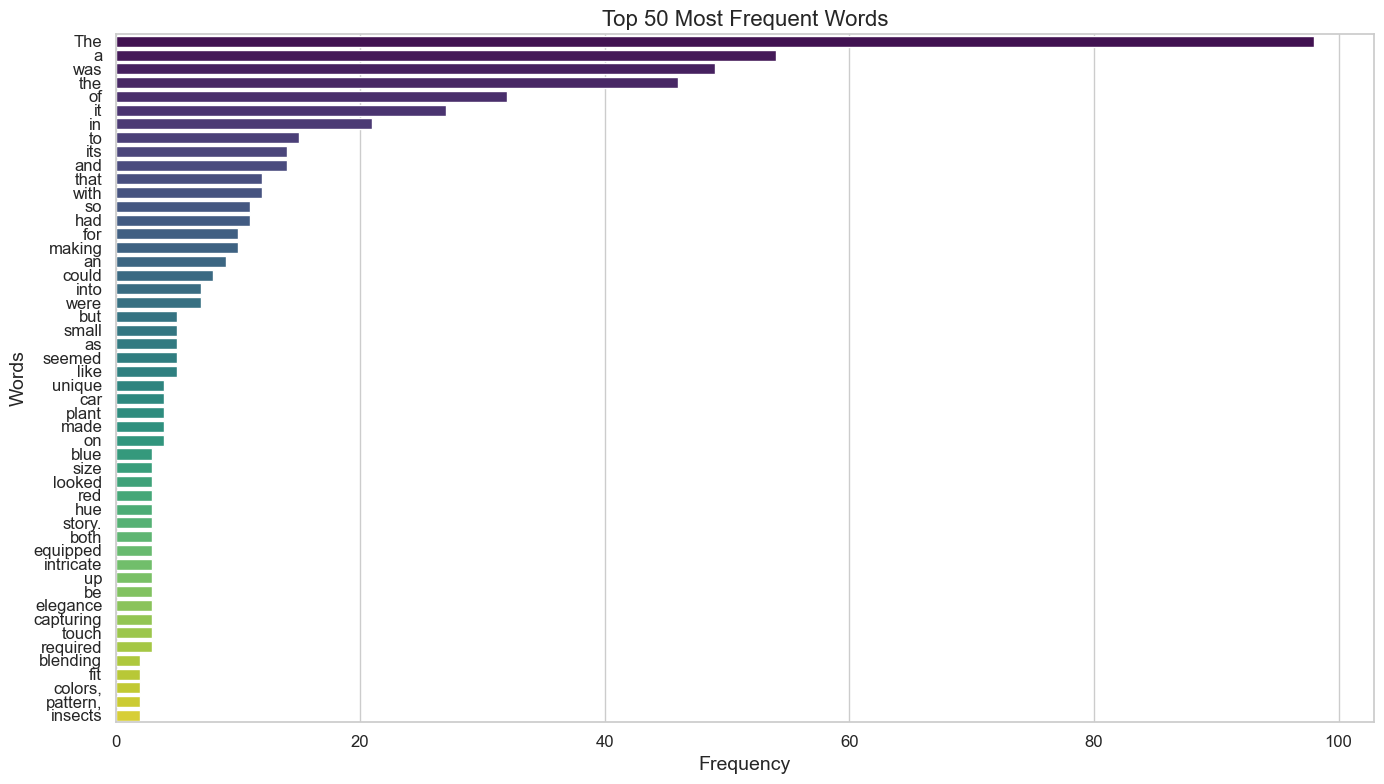

In [2]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

df = pd.DataFrame(sentences, columns=['sentence'])

all_words = df['sentence'].str.split(expand=True).stack().value_counts()

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Top 50 bar plot of uncleaned words
plt.figure(figsize=(14, 8))
top_words = all_words.head(50)
sns.barplot(x=top_words.values, y=top_words.index, palette="viridis")

plt.title('Top 50 Most Frequent Words', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Words', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

We are going to create some knowledge graph in order to understand the data better.

In [6]:
import re
import requests
import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")

from spacy.matcher import Matcher
from spacy.tokens import Span

import networkx as nx
from tqdm import tqdm

In [8]:
# Function to extract subject and object relations from sentences
def get_entities(sent):
    ## Chunk 1
    ent1 = "" # Subject
    ent2 = "" # Object
    
    prv_tok_dep = ""    # Dependency tag of previous token in the sentence
    prv_tok_text = ""   # Previous token in the sentence
    
    prefix = "" # Prefix of the dependency tag
    modifier = "" # Modifier of the dependency tag
    
    for tok in nlp(sent):
        ## Chunk 2
        # Check if token is a punctuation mark, if yes, ignore it
        if tok.dep_ != "punct":
            # Check if token is a compound word
            if tok.dep_ == "compound":
                prefix = tok.text
                # If the previous word was also a 'compound' word, add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " "+ tok.text
        
            # Check if token is a modifier
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # If the previous word was also a 'compound' word, add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " "+ tok.text
            
            ## Chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier +" "+ prefix + " "+ tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""
            
            ## Chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier +" "+ prefix +" "+ tok.text
            
            ## Chunk 5
            # Update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
            
    return [ent1.strip(), ent2.strip()]


In [15]:
# Check how it works
doc = sentences[2]
for tok in nlp(doc):
    print(tok.text, "-->",tok.dep_)
print(sentences[2])
print(get_entities(sentences[2]))

The --> det
fur --> compound
pattern --> nsubj
on --> prep
the --> det
tiger --> pobj
was --> aux
striking --> ROOT
and --> cc
intimidating --> conj
. --> punct
The fur pattern on the tiger was striking and intimidating.
['fur pattern', 'tiger']


In [16]:
# Now we can extract this entities from all the data
entity_pairs = []

for i in tqdm(sentences):
    entity_pairs.append(get_entities(i))

100%|██████████| 100/100 [00:00<00:00, 168.09it/s]


The pattern defined in the function tries to find the ROOT word or the main verb in the sentence. Once the ROOT is identified, then the pattern checks whether it is followed by a preposition (‘prep’) or an agent word. If yes, then it is added to the ROOT word

In [20]:
# Now we are going to extract the relationship (predicate), following the spaCy rule-based matching. 

def get_relation(sent):
    
    doc = nlp(sent)
    
    # matcher class object
    matcher = Matcher(nlp.vocab) # Matcher class object is used to match token patterns like regular expressions
    
    pattern = [{'DEP':'ROOT'},
                {'DEP':'prep','OP':"?"},
                {'DEP':'agent','OP':"?"},  # agent is a noun phrase
                {'POS':'ADJ','OP':"?"}]
    
    matcher.add("matching_1", [pattern])
    
    matches = matcher(doc)
    k = len(matches) - 1
    
    span = doc[matches[k][1]:matches[k][2]] # Extract the matched part
    
    return(span.text)
    
    

In [23]:
doc = sentences[2]
for tok in nlp(doc):
    print(tok.text, "-->",tok.dep_)
print(sentences[2])
print(get_entities(sentences[2]))
print(get_relation(sentences[2]))

The --> det
fur --> compound
pattern --> nsubj
on --> prep
the --> det
tiger --> pobj
was --> aux
striking --> ROOT
and --> cc
intimidating --> conj
. --> punct
The fur pattern on the tiger was striking and intimidating.
['fur pattern', 'tiger']
striking


In [24]:
relations = [get_relation(i) for i in tqdm(sentences)]
pd.Series(relations).value_counts()[:50]

100%|██████████| 100/100 [00:00<00:00, 145.47it/s]


was                          18
had                           8
were                          4
made                          4
equipped with                 2
was small                     2
formed                        2
displayed                     2
seemed                        2
sparkled like                 1
changed                       1
feathers of                   1
maintained                    1
was enormous                  1
was capable                   1
covered                       1
done in                       1
was silver                    1
customized with elaborate     1
crafted from                  1
cherished for                 1
telling                       1
was sleek                     1
curl                          1
had aerodynamic               1
appeared bizarre              1
lit                           1
served as                     1
was elegant                   1
was tiny                      1
carved                        1
created 

In [26]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

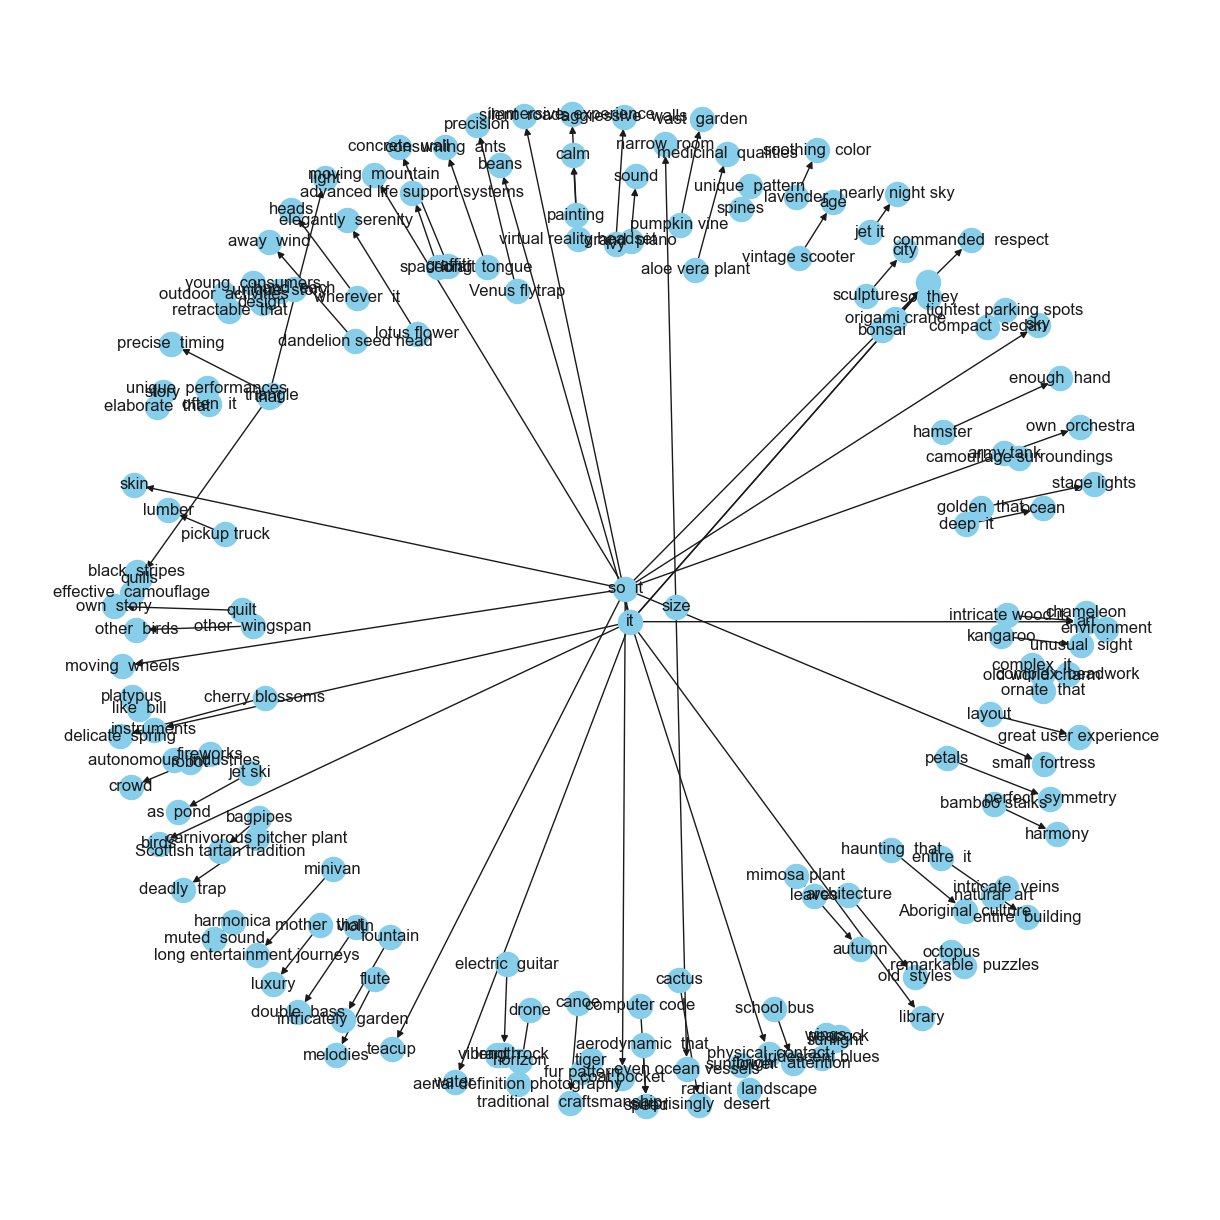

In [27]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
                          
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

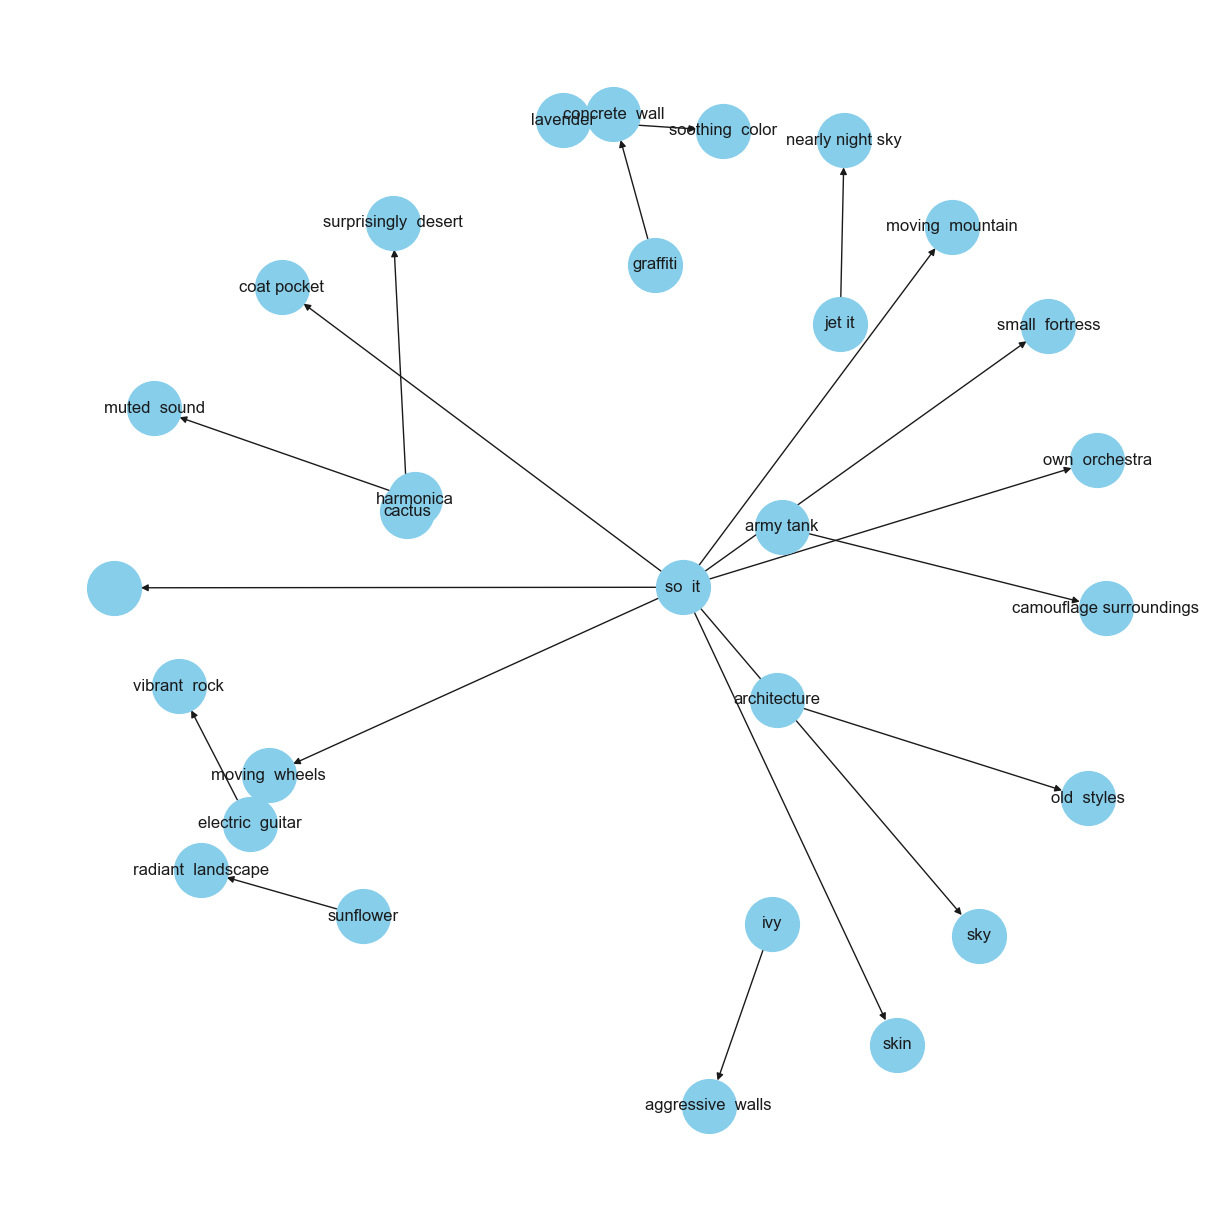

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="was"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

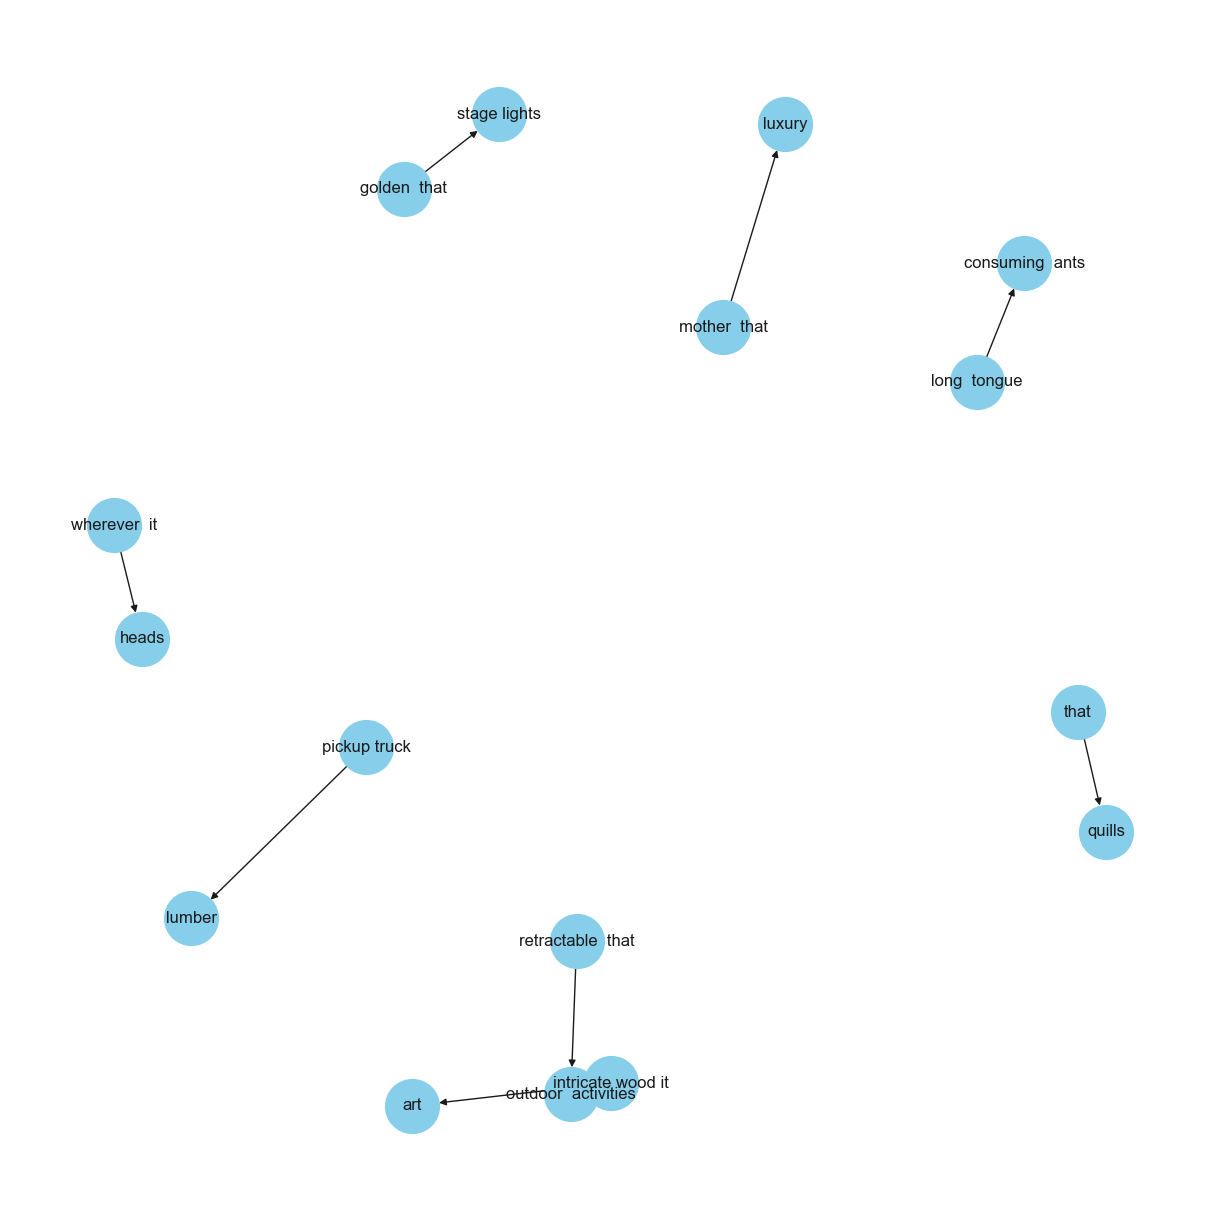

In [31]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="had"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

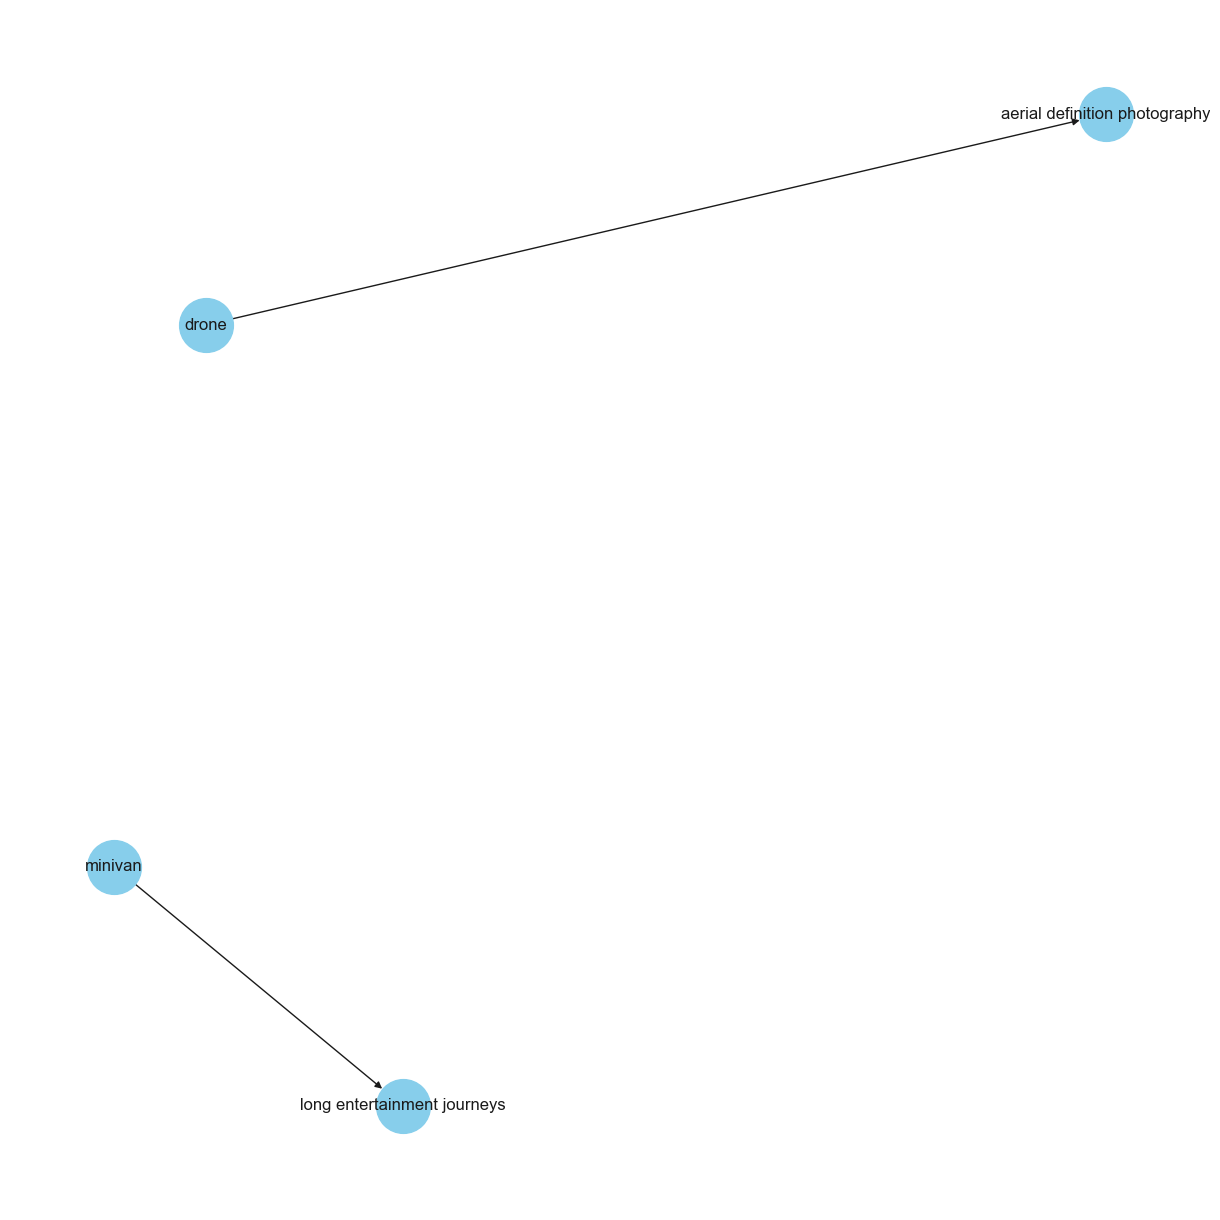

In [30]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="equipped with"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()